# Demo2

In [256]:
%matplotlib inline
import gc
import time
import fpfs

import os
import numpy as np
import matplotlib.pyplot as plt
import numpy.lib.recfunctions as rfn

## image simulation
+ In this demo we add noise on PSF models to mimic PSF modelling errors. Each PSF has different noise realizations.

SNR is 26.06


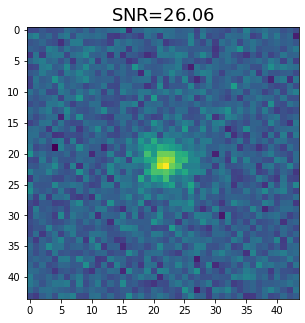

In [257]:
rng     =   np.random.RandomState(212)
testTask=   fpfs.simutil.sim_test(shear=[0,0],rng=rng)
ngrid   =   testTask.img.shape[0]
flux_gal=   np.sum(testTask.img[ngrid//2-2:ngrid//2+3,ngrid//2-2:ngrid//2+3])
noi_std =   3e-3
psf_noi =   1e-3
print('SNR is %.2f' %(flux_gal/(noi_std*5)))
gal,psf= testTask.make_image(noise=noi_std,psf_noise=psf_noi)
plt.close()
plt.figure(figsize=(5,5))
plt.imshow(gal)
_=plt.title(r'SNR=$%.2f$'%(flux_gal/(noi_std*5)),fontsize=18)

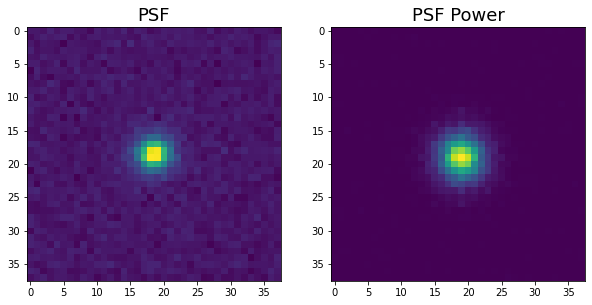

In [258]:
plt.close()
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(1,2,1)
ax.imshow(psf)
_=ax.set_title('PSF',fontsize=18)

ax=fig.add_subplot(1,2,2)
ax.imshow(psf)
ax.imshow(fpfs.imgutil.getFouPow(psf))
_=ax.set_title('PSF Power',fontsize=18)

# shear estimation

In [259]:
def analyze_FPFS(rng:np.random.RandomState, input_shear:np.ndarray, num_gals:int,\
        noi_stds,noi_psf=1e-9):
    noi_stds=   np.array(noi_stds)
    if len(noi_stds.shape)==0:
        noi_stds=np.array([noi_stds])
    elif len(noi_stds.shape)>=2:
        raise ValueError('The input noi_stds should be float or 1d list')
    x = []      # SNR
    y1 = []      # estimated shear
    y1_err = []      # error on shear
    y2 = []      # estimated shear
    y2_err = []      # error on shear
    if not os.path.exists("./images/"):
        os.mkdir("./images/")
        
    # I am calling this task to simulate galaxy images:
    # https://github.com/mr-superonion/FPFS/blob/188ba8679b4db401129e7504ea5126143bafdee4/fpfs/simutil.py#L163
    testTask=   fpfs.simutil.sim_test(shear=input_shear,rng=rng)
    # get an aperture flux for SNR estimation
    ngrid   =   testTask.img.shape[0]
    flux_gal=   np.sum(testTask.img[ngrid//2-2:ngrid//2+3,ngrid//2-2:ngrid//2+3])
    # cutout PSF into postage stamp with width=2rcut
    rcut    =   16
    psf0    =   fpfs.imgutil.cut_img(testTask.psf,rcut)
    gc.collect()
    num_tests=  noi_stds.size
    for i in range(num_tests):
        noii    =   noi_stds[i]
        x.append(flux_gal/(noii*5))
        start= time.time()
        # initialize FPFS task with an average psf and noise variance (or power spectrum)
        # beta<1 is the FPFS scale parameter
        fpTask  =   fpfs.fpfsBase.fpfsTask(psf0,noiFit=noii**2.,beta=0.75)
        results =   []
        for idx in range(num_gals):
            # simulate one galaxy
            gal, psf =   testTask.make_image(noise=noii, psf_noise=noi_psf)
            # cut out psf into 32x32 grids
            psf     =   fpfs.imgutil.cut_img(psf,rcut)
            psfPow  =   fpfs.imgutil.getFouPow(psf,noi_psf**2.)
            # cut out galaxy into 32x32 grids
            gal     =   fpfs.imgutil.cut_img(gal,rcut)
            # FPFS measurement
            modes=  fpTask.measure(gal,psfPow=psfPow)
            # append measured modes to the results list
            results.append(modes)
            # del gal,modes,psfPow
        # visualize
        plt.close()
        plt.figure(figsize=(15,8))
        plt.subplot(1,3,1)
        plt.imshow(psf)
        plt.title('PSF', fontsize=16)
        plt.subplot(1,3,2)
        plt.imshow(psfPow)
        plt.title('PSF Power', fontsize=16)
        plt.subplot(1,3,3)
        plt.imshow(gal)
        plt.title('Galaxy', fontsize=16)
        plt.savefig('./images/gal_%.5f.jpg' %(noii))
        plt.show()
        
        gc.collect()
        mms =   rfn.stack_arrays(results,usemask=False)
        # set C = std(\delta M_00)
        C   =   np.sqrt(np.average(mms['fpfs_N00N00']))*5.
        ells=   fpfs.fpfsBase.fpfsM2E(mms,const=C,noirev=False)
        del mms,results
        resp=np.average(ells['fpfs_RE'])
        shear_1=np.average(ells['fpfs_e1'])/resp
        shear_2=np.average(ells['fpfs_e2'])/resp
        shear_1_err=np.std(ells['fpfs_e1'])/np.abs(resp)/np.sqrt(num_gals)
        shear_2_err=np.std(ells['fpfs_e2'])/np.abs(resp)/np.sqrt(num_gals)
        end =   time.time()
        print('%.5f seconds to process %d galaxies (noise=%.5f)\n' %(end-start,num_gals,noii))
        y1.append(shear_1)
        y1_err.append(shear_1_err)
        y2.append(shear_2)
        y2_err.append(shear_2_err)
    return np.array(x), np.array(y1), np.array(y1_err), np.array(y2), np.array(y2_err)

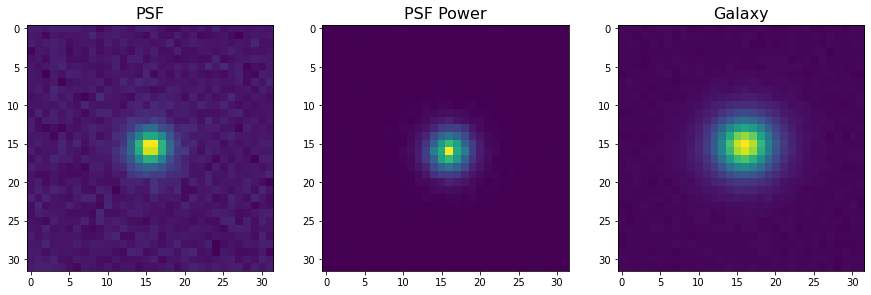

1.58084 seconds to process 5000 galaxies (noise=0.00010)



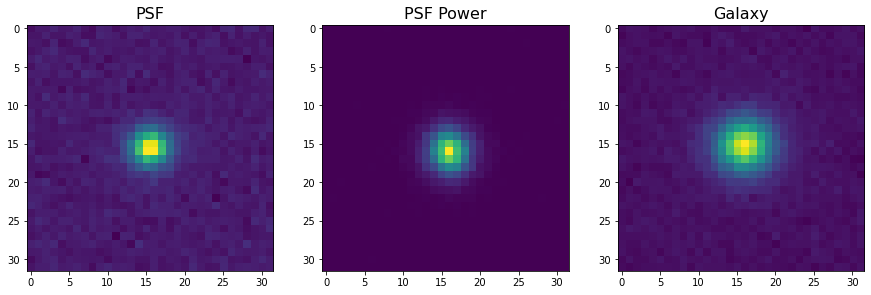

1.67946 seconds to process 5000 galaxies (noise=0.00032)



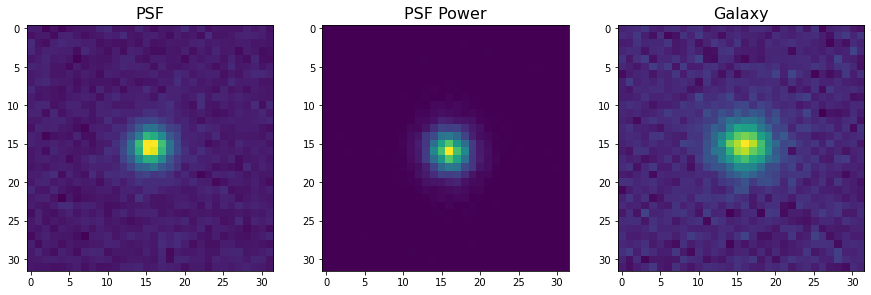

1.72428 seconds to process 5000 galaxies (noise=0.00100)



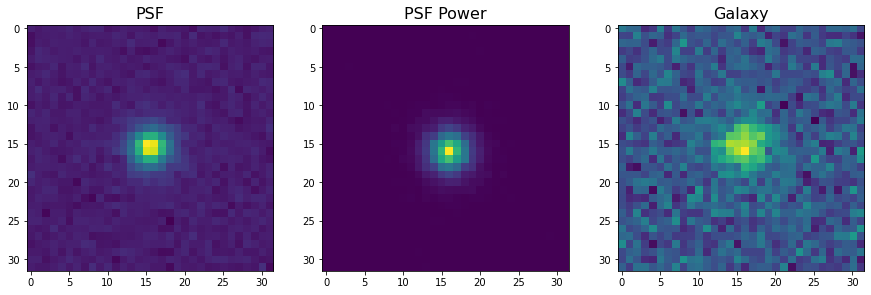

1.64556 seconds to process 5000 galaxies (noise=0.00316)



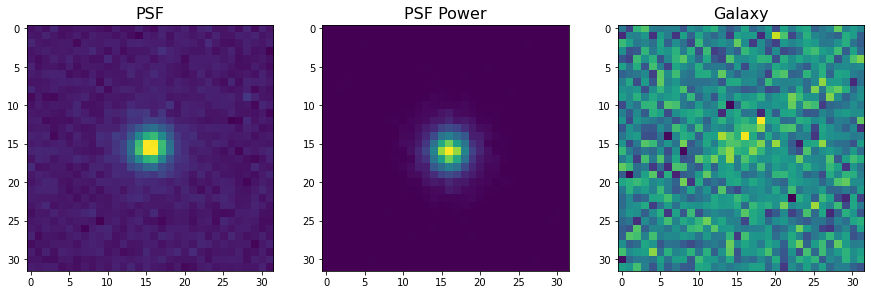

1.56032 seconds to process 5000 galaxies (noise=0.01000)



In [260]:
rng = np.random.RandomState(212)
noi_stds = np.logspace(-4, -2, 5, base=10.0)
num_gals = 5000
shear = np.array([0.04, 0.01])
snr, g1, g1err, g2, g2err = analyze_FPFS(rng, shear, num_gals, noi_stds, noi_psf=1e-3)

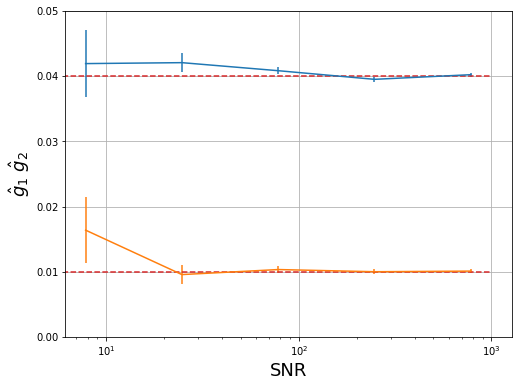

In [265]:
plt.close()
fig=plt.figure(figsize=(8,6))
plt.errorbar(snr, g1, g1err, ecolor='tab:blue')
plt.errorbar(snr, g2, g2err, ecolor='tab:orange')
plt.xlabel('SNR', fontsize=18)
plt.ylabel(r'$\hat{g}_1$ $\hat{g}_2$', fontsize=18)
plt.grid()
plt.hlines(shear[0], 0, 1000, color='tab:red', linestyles='dashed')
plt.hlines(shear[1], 0, 1000, color='tab:red', linestyles='dashed')
plt.ylim(0,0.05)
plt.xscale('log')